In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from tqdm.notebook import tqdm
import sys
import os

# Add parent directory to path for imports
sys.path.append('..')

In [2]:
# Import project modules 
from dataset_preprocessing.dataset import BUSIDataset, create_data_loaders
from models.unet import UNet
from models.loss import dice_loss, combined_loss
from models.metrics import calculate_metrics, visualize_results

In [3]:
# 1. Set up training parameters
BATCH_SIZE = 8
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
PATIENCE = 5  # For early stopping and LR reduction
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = './saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")

Using device: cpu


In [4]:
# 2. Load dataset and create data loaders
data_dir = "../Dataset_BUSI_with_GT/benign"

train_loader, val_loader = create_data_loaders(
    data_dir=data_dir,
    batch_size=BATCH_SIZE,
    train_val_split=0.8,
    denoising_method="bilateral",
    num_workers=4
)

print(f"Training on {len(train_loader.dataset)} samples")
print(f"Validating on {len(val_loader.dataset)} samples")

Found 437 image-mask pairs in ../Dataset_BUSI_with_GT/benign
Using bilateral denoising method
Created data loaders with 44 training batches and 11 validation batches
Training on 349 samples
Validating on 88 samples


In [5]:
# 3. Initialize model and training components
model = UNet(in_channels=1, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=PATIENCE//2, verbose=True)
criterion = combined_loss

/home/kacper/Documents/Projects/AI-ML-tasks/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
# 4. Training utilities
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """Train the model for one epoch"""
    model.train()
    epoch_loss = 0
    
    with tqdm(dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            # Get data
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update metrics
            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())
    
    return epoch_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    val_loss = 0
    dice_scores = []
    iou_scores = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Get data
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            # Calculate metrics
            probs = torch.sigmoid(outputs)
            metrics = calculate_metrics(probs, masks)
            dice_scores.append(metrics['dice'])
            iou_scores.append(metrics['iou'])
    
    # Calculate average metrics
    avg_val_loss = val_loss / len(dataloader)
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    
    return avg_val_loss, avg_dice, avg_iou

In [9]:
# 5. Training loop with early stopping
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, device, patience):
    """Full training loop with early stopping"""
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = 0.0
    no_improve_epochs = 0
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    dice_scores = []
    iou_scores = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        # Validate
        val_loss, dice, iou = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        dice_scores.append(dice)
        iou_scores.append(iou)
        
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice: {dice:.4f}, IoU: {iou:.4f}")
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Check if this is the best model so far
        if dice > best_dice:
            best_dice = dice
            best_model_wts = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'dice': dice,
                'iou': iou,
            }, os.path.join(SAVE_DIR, 'best_model.pth'))
            
            print(f"New best model saved! Dice: {dice:.4f}")
        else:
            no_improve_epochs += 1
        
        # Early stopping
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return metrics history for plotting
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'dice': dice_scores,
        'iou': iou_scores,
    }
    
    return model, history

In [10]:
# 6. Execute the training
start_time = time.time()
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    patience=PATIENCE
)
total_time = time.time() - start_time
print(f"Training completed in {total_time/60:.2f} minutes")

Epoch 1/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.4994, Val Loss: 0.4434, Dice: 0.3638, IoU: 0.2341
New best model saved! Dice: 0.3638
Epoch 2/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.4167, Val Loss: 0.4575, Dice: 0.4131, IoU: 0.2642
New best model saved! Dice: 0.4131
Epoch 3/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.3842, Val Loss: 0.3225, Dice: 0.5536, IoU: 0.3902
New best model saved! Dice: 0.5536
Epoch 4/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.3549, Val Loss: 0.3355, Dice: 0.5786, IoU: 0.4147
New best model saved! Dice: 0.5786
Epoch 5/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.3548, Val Loss: 0.3818, Dice: 0.5034, IoU: 0.3452
Epoch 6/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.3332, Val Loss: 0.2677, Dice: 0.6487, IoU: 0.4875
New best model saved! Dice: 0.6487
Epoch 7/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.3083, Val Loss: 0.3003, Dice: 0.6120, IoU: 0.4472
Epoch 8/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.2972, Val Loss: 0.3274, Dice: 0.5444, IoU: 0.3807
Epoch 9/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.3118, Val Loss: 0.3163, Dice: 0.5667, IoU: 0.4005
Epoch 10/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.2782, Val Loss: 0.2584, Dice: 0.6603, IoU: 0.5024
New best model saved! Dice: 0.6603
Epoch 11/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.2617, Val Loss: 0.2272, Dice: 0.7036, IoU: 0.5483
New best model saved! Dice: 0.7036
Epoch 12/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.2621, Val Loss: 0.2539, Dice: 0.6599, IoU: 0.5023
Epoch 13/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.2376, Val Loss: 0.2416, Dice: 0.6803, IoU: 0.5251
Epoch 14/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.2314, Val Loss: 0.3569, Dice: 0.5459, IoU: 0.3841
Epoch 15/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.2184, Val Loss: 0.2384, Dice: 0.6909, IoU: 0.5358
Epoch 16/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1863, Val Loss: 0.2190, Dice: 0.7125, IoU: 0.5613
New best model saved! Dice: 0.7125
Epoch 17/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1938, Val Loss: 0.2481, Dice: 0.6673, IoU: 0.5097
Epoch 18/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1875, Val Loss: 0.2204, Dice: 0.7089, IoU: 0.5553
Epoch 19/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1793, Val Loss: 0.2461, Dice: 0.6672, IoU: 0.5115
Epoch 20/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1640, Val Loss: 0.2170, Dice: 0.7156, IoU: 0.5651
New best model saved! Dice: 0.7156
Epoch 21/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1445, Val Loss: 0.2112, Dice: 0.7210, IoU: 0.5702
New best model saved! Dice: 0.7210
Epoch 22/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1433, Val Loss: 0.2207, Dice: 0.7084, IoU: 0.5558
Epoch 23/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1383, Val Loss: 0.2274, Dice: 0.7027, IoU: 0.5478
Epoch 24/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1314, Val Loss: 0.2229, Dice: 0.7037, IoU: 0.5525
Epoch 25/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1246, Val Loss: 0.2324, Dice: 0.6935, IoU: 0.5395
Epoch 26/30


  0%|          | 0/44 [00:00<?, ?batch/s]

Train Loss: 0.1183, Val Loss: 0.2218, Dice: 0.7110, IoU: 0.5598
Early stopping triggered after 26 epochs
Training completed in 72.70 minutes


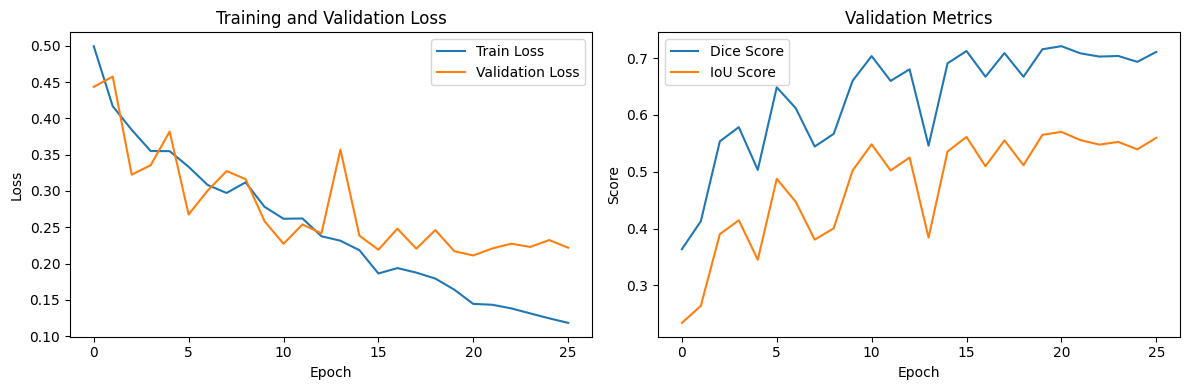

In [11]:
# 7. Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot metrics
plt.subplot(1, 2, 2)
plt.plot(history['dice'], label='Dice Score')
plt.plot(history['iou'], label='IoU Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics')

plt.tight_layout()
plt.show()


Evaluating model on validation set...

Test Results:
Dice: 0.7210
Iou: 0.5702
Precision: 0.7926
Recall: 0.6709


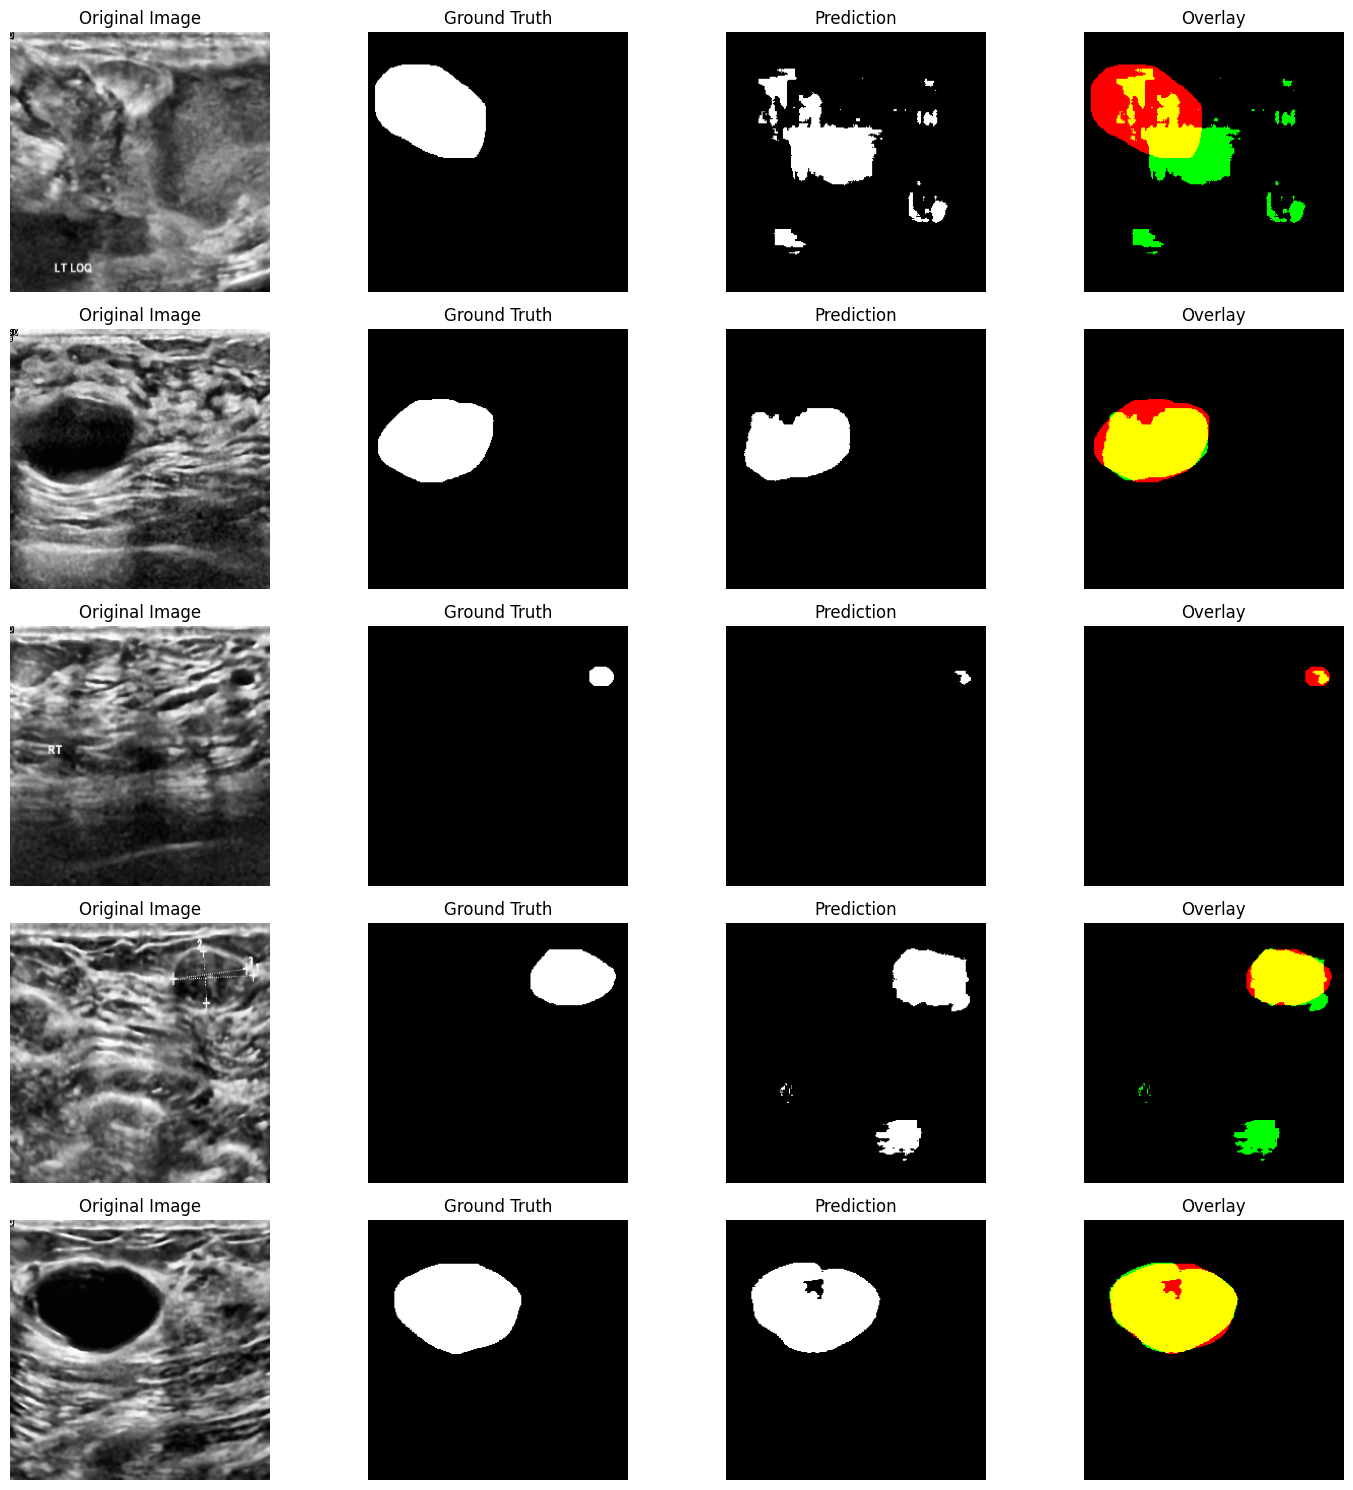

In [12]:
# 8. Test the model on validation set
def test_model(model, dataloader, device):
    """Comprehensive test of the model on a dataset"""
    model.eval()
    all_metrics = {
        'dice': [],
        'iou': [],
        'precision': [],
        'recall': [],
    }
    
    # Sample images for visualization
    sample_images = []
    sample_true_masks = []
    sample_pred_masks = []
    max_samples = 5
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # Get data
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            # Forward pass
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            
            # Calculate metrics
            metrics = calculate_metrics(probs, masks)
            for key in all_metrics:
                all_metrics[key].append(metrics[key])
            
            # Store samples for visualization
            if i < max_samples:
                sample_images.append(images[0].cpu())
                sample_true_masks.append(masks[0].cpu())
                sample_pred_masks.append(probs[0].cpu())
    
    # Calculate average metrics
    avg_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
    
    # Print metrics
    print("\nTest Results:")
    for key, value in avg_metrics.items():
        print(f"{key.capitalize()}: {value:.4f}")
    
    # Visualize samples
    num_samples = len(sample_images)
    plt.figure(figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(sample_images[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # True mask
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(sample_true_masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 4, i*4 + 3)
        pred_binary = (sample_pred_masks[i].squeeze() > 0.5).float().numpy()
        plt.imshow(pred_binary, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        
        # Overlay
        plt.subplot(num_samples, 4, i*4 + 4)
        original = sample_images[i].squeeze().numpy()
        overlay = np.zeros((*original.shape, 3), dtype=np.float32)
        overlay[..., 0] = sample_true_masks[i].squeeze().numpy()  # Red: true mask
        overlay[..., 1] = pred_binary  # Green: predicted mask
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return avg_metrics

# Run the test
print("\nEvaluating model on validation set...")
final_metrics = test_model(model, val_loader, DEVICE)

In [14]:
# 9. Print comparison to initial untrained model
print("\nMetrics Comparison:")
print("                 Before Training    After Training")
print(f"Dice:           0.0803             {final_metrics['dice']:.4f}")
print(f"IoU:            0.0418             {final_metrics['iou']:.4f}")
print(f"Precision:      0.0704             {final_metrics['precision']:.4f}")
print(f"Recall:         0.0936             {final_metrics['recall']:.4f}")


Metrics Comparison:
                 Before Training    After Training
Dice:           0.0803             0.7210
IoU:            0.0418             0.5702
Precision:      0.0704             0.7926
Recall:         0.0936             0.6709
